In [0]:
import numpy as np
import pandas as pd

from tqdm import tqdm
pd.options.mode.chained_assignment = None

In [81]:
df = pd.read_csv('/content/drive/My Drive/alldata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103624 entries, 0 to 103623
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    103624 non-null  int64  
 1   corpus_index  103624 non-null  int64  
 2   date          103624 non-null  object 
 3   direction     103624 non-null  object 
 4   ex_return     101996 non-null  float64
 5   ticker        103624 non-null  object 
 6   whole         103624 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 5.5+ MB


In [82]:
# preprocessing data: change format



df = df.dropna()
df['date'] = pd.to_datetime(df.date)

df['dir'] = df['direction'].apply(lambda x: 1 if x == 'up' else -1)
df = df.reset_index()
df.head()

,index,Unnamed: 0,corpus_index,date,direction,ex_return,ticker,whole,dir
0,0,62740,16,2001-01-25,down,-5.80473,LLY,on that managed short term symptoms are then b...,-1
1,1,62737,13,2001-01-25,down,-5.80473,LLY,is from Steve Tie's line from Merrill Lynch. P...,-1
2,2,62730,6,2001-01-25,down,-5.80473,LLY,"6%. Excluding the effect of exchange rates, an...",-1
3,3,62739,15,2001-01-25,down,-5.80473,LLY,year when we will be losing execution of the m...,-1
4,4,62729,5,2001-01-25,down,-5.80473,LLY,last year totalling $419 million. The decline ...,-1


In [83]:
df.groupby(['date', 'ticker']).first()

index  ...  dir
date       ticker          ...     
2001-01-25 LLY          0  ...   -1
2001-03-19 PAYX        17  ...    1
2001-04-03 BBY         32  ...    1
2001-04-04 THC         55  ...   -1
2001-04-11 HOG         76  ...    1
...                   ...  ...  ...
2005-12-22 GIS     103502  ...    1
           PAYX    103532  ...   -1
           SLR     103509  ...    1
           TMO     103523  ...   -1
2005-12-28 CELG    103614  ...    1

[6081 rows x 7 columns]

In [0]:
# train test split

val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)
train_size = int(df.shape[0] * 0.7)

train_ticker, train_date, train_corp, train_texts, train_ret, train_dir = df.ticker[:train_size], df.date[:train_size], df.corpus_index[:train_size], df.whole[:train_size], df.ex_return[:train_size], df.dir[:train_size]
val_ticker, val_date, val_corp, val_texts, val_ret, val_dir = df.ticker[train_size:train_size+val_size], df.date[train_size:train_size+val_size], df.corpus_index[train_size:train_size+val_size], df.whole[train_size:train_size+val_size], df.ex_return[train_size:train_size+val_size], df.dir[train_size:train_size+val_size]
test_ticker, test_date, test_corp, test_texts, test_ret, test_dir = df.ticker[train_size+val_size:], df.date[train_size+val_size:], df.corpus_index[train_size+val_size:], df.whole[train_size+val_size:], df.ex_return[train_size+val_size:], df.dir[train_size+val_size:]

In [0]:
# preprocess data: vectorize it


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

def tfidf(data, max_features):
    import nltk
    try: 
      stop_words = stopwords.words('english')
    except:
      nltk.download('stopwords')
      stop_words = stopwords.words('english')

    tfidf = TfidfVectorizer(stop_words = stop_words, max_features = max_features)
    model = tfidf.fit(data)

    return model


In [0]:
def accuracy_score(y_true, y_pred): 

    # Calculate accuracy of the model's prediction
    """
    YOUR CODE GOES HERE
    """
    true = 0
    total = int(len(y_true))
    for i in range(len(y_true)):
      if y_true[i] == y_pred[i]:
        true += 1
    
    accuracy = float(true)/float(total)
    return accuracy

def f1_score(y_true, y_pred): 
    tp=0
    fp=0
    tn=0
    fn=0
    for i in range(0,len(y_true)):
      if(y_true[i]==1 and y_pred[i]==1):
        tp+=1
      elif(y_true[i]==-1 and y_pred[i]==1):
        fp+=1
      elif(y_true[i]==-1 and y_pred[i]==-1):
        tn+=1
      elif(y_true[i]==1 and y_pred[i]==-1):
        fn+=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall) / (precision+recall)
    return f1


def get_accuracy(y_pred, df, set):

  data_set = {'train' : df[:train_size], 'val' : df[train_size:train_size+val_size], 'test' : df[train_size+val_size:]}
  df1 = data_set[set]

  df1['pred'] = y_pred
  agg_pred = df1.groupby(['ticker', 'date']).mean()['pred'].apply(lambda x: 1 if x > 0 else -1).values.tolist()
  true_pred = df1.groupby(['ticker', 'date']).first().dir.values.tolist()
  acc = accuracy_score(agg_pred, true_pred)
  f1 = f1_score(agg_pred, true_pred)
  return acc, f1

In [0]:
# transform data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB

def surprise_me(train_texts, val_texts, test_texts, df, max_features, alpha):
    vectorizer = tfidf(train_texts, max_features = max_features)
    X_train= vectorizer.transform(train_texts)
    X_val= vectorizer.transform(val_texts)
    X_test= vectorizer.transform(test_texts)


    y_train = np.array(train_dir)
    y_val = np.array(val_dir)
    y_test = np.array(test_dir)


    model = ComplementNB(alpha = alpha)

    model.fit(X_train, y_train)

    # Make prediction using the trained model
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_acc, train_f1 = get_accuracy(y_train_pred, df, 'train')
    val_acc, val_f1 = get_accuracy(y_val_pred, df, 'val')
    test_acc, test_f1 = get_accuracy(y_test_pred, df, 'test')
    
    report = pd.DataFrame({'acc': [train_acc,val_acc,test_acc], 'f1':[train_f1, val_f1,test_f1]})
    report.index = ['train', 'val', 'test']

    print('surprise mf!')
    print('classification with Naive Bayes')
    return report

In [101]:
surprise_me(train_texts, val_texts, test_texts, df, 500, 0.01)

surprise mf!
classification with Naive Bayes


,acc,f1
train,0.567182,0.567285
val,0.540084,0.433766
test,0.566806,0.450331


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline



def get_scores(train_texts, val_texts, test_texts, df, max_features_list):
    accs = []
    f1s = []
    for x in tqdm(max_features_list):
      for a in alpha_list:
        vectorizer = tfidf(train_texts, max_features = max_features)
        X_train= vectorizer.transform(train_texts)
        X_val= vectorizer.transform(val_texts)


        y_train = np.array(train_dir)
        y_val = np.array(val_dir)

        model = ComplementNB(alpha = a)
        model.fit(X_train, y_train)
        # Make prediction using the trained model
        y_val_pred = model.predict(X_val)
        val_acc, val_f1 = get_accuracy(y_val_pred, df, 'val')
        accs.append(val_acc)
        f1s.append(val_f1)

    return accs, f1s

def get_top(features, alpha, score):
    highest_score = sorted(score, reverse = True)[0]
    highest_idx = score.index(highest_score)
    max_feature_idx = highest_idx//len(features)
    # max_feature_idx = np.floor(float(highest_idx)/float(len(features)))
    a_idx = highest_idx % len(features)
    return features[max_feature_idx], alpha[a_idx], highest_score
    

def show_me_max_feature(max_features_list,alpha_list, alpha, accs, f1s):
    max_features_big_list = []
    alpha_big_list = []

    for x in max_features_list:
      for a in alpha_list:
        max_features_big_list.append(x)
        alpha_big_list.append(a)

    df = pd.DataFrame({'max_feature': max_features_big_list, 'alpha': alpha_big_list, 
                       'accs' : accs, 'f1s' : f1s})
    data = df[df['alpha'] == alpha].sort_values(by = 'max_feature')
    accs = data.accs
    f1s = data.f1s
    plt.plot(max_features_list, accs,'r--', max_features_list,f1s)
    plt.legend(['acc', 'f1'])
    plt.xlabel('max_features')
    plt.ylabel('scores')
    plt.show()
    
def show_me_alpha(max_feature_list, alpha_list, max_feature, accs, f1s):
    max_features_big_list = []
    alpha_big_list = []

    for x in max_features_list:
      for a in alpha_list:
        max_features_big_list.append(x)
        alpha_big_list.append(a)

    df = pd.DataFrame({'max_feature': max_features_big_list, 'alpha_list': alpha_big_list, 
                       'accs' : accs, 'f1s' : f1s})
    data = df[df['max_feature'] == max_feature].sort_values(by = 'alpha_list')

    accs = data.accs

    f1s = data.f1s
    plt.plot(alpha_list, accs,'r--', alpha_list,f1s)
    plt.legend(['acc', 'f1'])
    plt.xlabel('alpha')
    plt.ylabel('scores')
    plt.show()

    

In [103]:
max_features_list = [500, 1000,1500,2000,2500,3000]
alpha_list = [0.01, 0.1, 1]
accs, f1s = get_scores(train_texts, val_texts, test_texts, df, max_features_list)




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:53<09:26, 113.31s/it]

 33%|███▎      | 2/6 [03:47<07:33, 113.45s/it]

 50%|█████     | 3/6 [05:39<05:39, 113.28s/it]

 67%|██████▋   | 4/6 [07:34<03:47, 113.63s/it]

 83%|████████▎ | 5/6 [09:28<01:53, 113.75s/it]

100%|██████████| 6/6 [11:21<00:00, 113.60s/it]


(param_acc, top_acc):  (500, 1, 0.5305907172995781)
(param_f1, top_f1):  (500, 1, 0.4198174706649283)


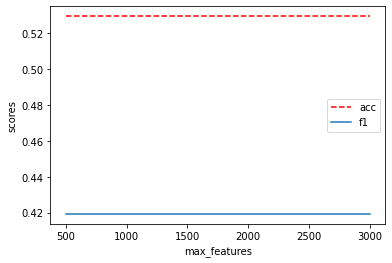

In [104]:
print('(param_acc, top_acc): ', get_top(max_features_list,alpha_list, accs))
print('(param_f1, top_f1): ',  get_top(max_features_list,alpha_list, f1s))
show_me_max_feature(max_features_list,alpha_list,0.01, accs, f1s)

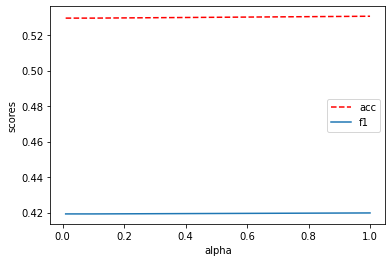

In [108]:
show_me_alpha(max_features_list,alpha_list, 1000, accs, f1s)

In [0]:


from sklearn.linear_model import Lasso
def better_not_surprise_me(train_texts, val_texts, test_texts, df, max_features, alpha):
    vectorizer = tfidf(train_texts, max_features = max_features)
    X_train= vectorizer.transform(train_texts)
    X_val= vectorizer.transform(val_texts)
    X_test= vectorizer.transform(test_texts)

    y_train = np.array(train_dir)
    y_val = np.array(val_dir)
    y_test = np.array(test_dir)


    model = Lasso(alpha = alpha)

    model.fit(X_train, y_train)

    # Make prediction using the trained model
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_acc, train_f1 = get_accuracy(y_train_pred, df, 'train')
    val_acc, val_f1 = get_accuracy(y_val_pred, df, 'val')
    test_acc, test_f1 = get_accuracy(y_test_pred, df, 'test')
    
    report = pd.DataFrame({'acc': [train_acc,val_acc,test_acc], 'f1':[train_f1, val_f1,test_f1]})
    report.index = ['train', 'val', 'test']

    print('surprise mf!')
    return report

In [111]:
better_not_surprise_me(train_texts, val_texts, test_texts, df, 1500, 0.1)

surprise mf!


,acc,f1
train,0.533888,0.696124
val,0.407173,0.578711
test,0.462422,0.632405


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline



def get_scores2(train_texts, val_texts, test_texts, df, max_features_list):
    accs = []
    f1s = []
    for x in tqdm(max_features_list):
      for a in alpha_list:
        vectorizer = tfidf(train_texts, max_features = max_features)
        X_train= vectorizer.transform(train_texts)
        X_val= vectorizer.transform(val_texts)



        y_train = np.array(train_dir)
        y_val = np.array(val_dir)


      
        model = Lasso(alpha = a)
        model.fit(X_train, y_train)
        # Make prediction using the trained model
        y_val_pred = model.predict(X_val)
        val_acc, val_f1 = get_accuracy(y_val_pred, df, 'val')
        accs.append(val_acc)
        f1s.append(val_f1)

    return accs, f1s




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:52<07:31, 112.88s/it]

 40%|████      | 2/5 [03:48<05:40, 113.63s/it]

 60%|██████    | 3/5 [05:41<03:46, 113.42s/it]

 80%|████████  | 4/5 [07:34<01:53, 113.31s/it]

100%|██████████| 5/5 [09:27<00:00, 113.48s/it]


(param_acc, top_acc):  (200, 1, 0.5305907172995781)
(param_f1, top_f1):  (200, 1, 0.4198174706649283)


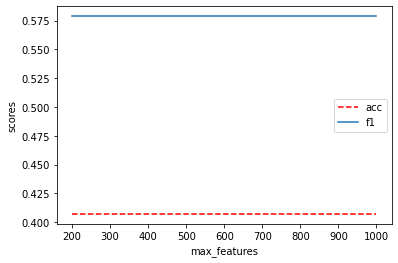

In [114]:
max_features_list = np.linspace(200, 1000, 5, dtype = int)
# max_features_list = [100, 1000,1500,2000,2500,3000]
alpha_list = [0.01, 0.1, 1]
accs2, f1s2 = get_scores2(train_texts, val_texts, test_texts, df, max_features_list)


(param_acc, top_acc):  (200, 1, 0.5305907172995781)
(param_f1, top_f1):  (200, 1, 0.4198174706649283)


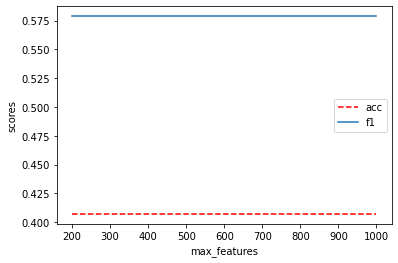

In [115]:

print('(param_acc, top_acc): ', get_top(max_features_list,alpha_list, accs))
print('(param_f1, top_f1): ',  get_top(max_features_list,alpha_list, f1s))
show_me_max_feature(max_features_list,alpha_list, 0.01, accs2, f1s2)

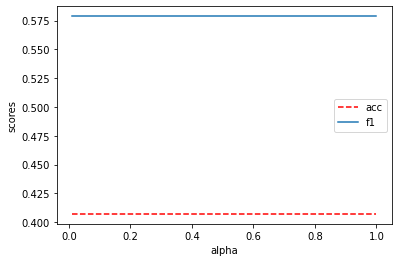

In [116]:
show_me_alpha(max_features_list,alpha_list, 1000, accs2, f1s2)

In [0]:
f1s2

In [0]:
accs